# Nonlinear (np.cos) Regression with SGD

This notebook evaluates convergence behavior and generalization performance of SGD on data generated in the form of $y = cos(x) + b + noise$ on our linear/polynomial regression model. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error over 20 randomized trials. We can observe how well a linear model class performs with nonlinearly (in this case, cosine) generated data.

In [10]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import generate_training_data_unfixed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Summary of Train/Test Error Over 20 Runs

We generate new synthetic data each time and report mean ± std of final losses.

In [11]:
n_runs = 20
degrees = [1, 2, 3, 4]
noise = 0.01
m, n = 100, 1  
results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}

    for run in range(n_runs):
        X, _, y, _ = generate_training_data_unfixed(
            m=m, n=n, noise=noise, model_type='nonlinear', nonlinear_func=np.cos
        )
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train = poly.fit_transform(X_train_raw)
        X_test = poly.transform(X_test_raw)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for method in ["fixed", "halving", "diminishing"]:
            sgd = SGD(X_train, y_train, num_iterations=5000, noise=noise) 
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])

            test_pred = X_test @ w[1:] + w[0]  
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print summary
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")


Degree 1:
Fixed Results:
  Train Loss  - Mean: 0.1435, Std: 0.2568
  Test Loss   - Mean: 0.4364, Std: 0.8633
Halving Results:
  Train Loss  - Mean: 0.0344, Std: 0.0194
  Test Loss   - Mean: 0.1038, Std: 0.0820
Diminishing Results:
  Train Loss  - Mean: 0.0340, Std: 0.0189
  Test Loss   - Mean: 0.1038, Std: 0.0827

Degree 2:
Fixed Results:
  Train Loss  - Mean: 0.0316, Std: 0.0295
  Test Loss   - Mean: 0.1126, Std: 0.1159
Halving Results:
  Train Loss  - Mean: 0.0246, Std: 0.0234
  Test Loss   - Mean: 0.0867, Std: 0.0902
Diminishing Results:
  Train Loss  - Mean: 0.0226, Std: 0.0148
  Test Loss   - Mean: 0.0798, Std: 0.0847

Degree 3:
Fixed Results:
  Train Loss  - Mean: 0.0114, Std: 0.0029
  Test Loss   - Mean: 0.0283, Std: 0.0238
Halving Results:
  Train Loss  - Mean: 0.0113, Std: 0.0030
  Test Loss   - Mean: 0.0295, Std: 0.0266
Diminishing Results:
  Train Loss  - Mean: 0.0118, Std: 0.0028
  Test Loss   - Mean: 0.0319, Std: 0.0281

Degree 4:
Fixed Results:
  Train Loss  - Mean: 0.08

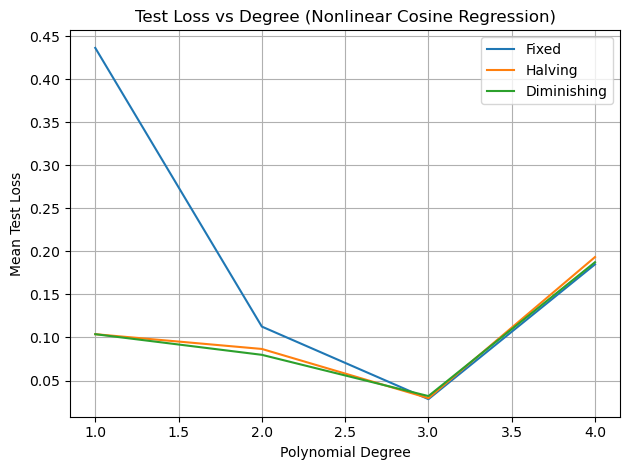

In [12]:
for method in ["fixed", "halving", "diminishing"]:
    test_means = [np.mean(results_summary[d]["test"][method]) for d in degrees]
    plt.plot(degrees, test_means, label=f"{method.capitalize()}")

plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Test Loss")
plt.title("Test Loss vs Degree (Nonlinear Cosine Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
X_raw, _, y, true_params = generate_training_data_unfixed(
    m=100, n=1, noise=0.01, model_type='nonlinear', nonlinear_func=np.cos
)
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X_raw)
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

results = {}
for method in ["fixed", "halving", "diminishing"]:
    sgd = SGD(X_poly, y, num_iterations=5000, noise=0.01)
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {"w": w, "obj": obj, "grad": grad, "dist": dist}

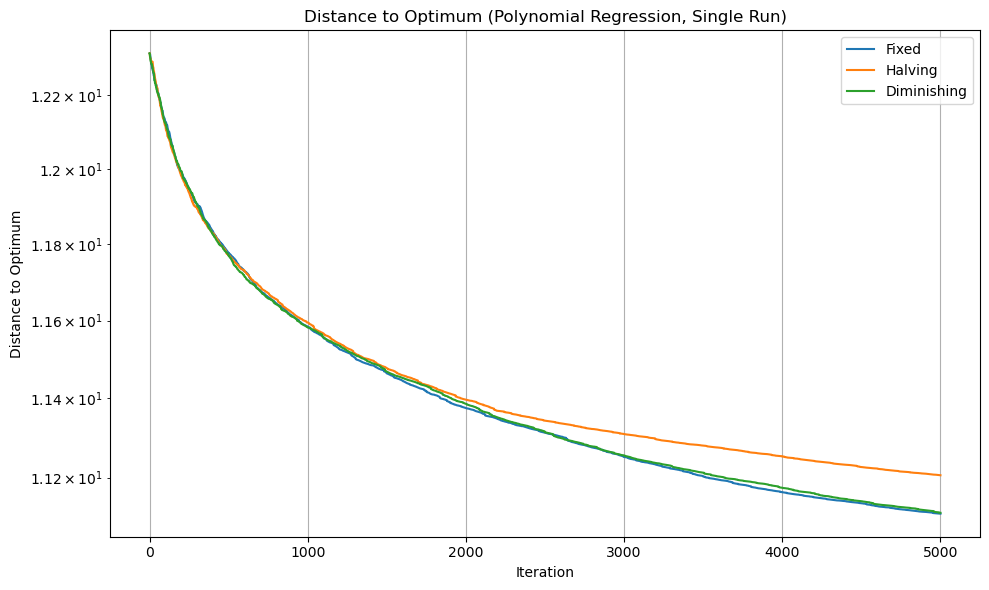

In [ ]:
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Nonlinear (np.cos) Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
print("SGD Parameters for Nonlinear (np.cos) Run (degree = 3):")
print("="*60)
print(f"L (Lipschitz constant):        {sgd.L:.4f}")
print(f"c (strong convexity):          {sgd.c:.4f}")
print(f"M:                             {sgd.M:.4f}")
print(f"M_V:                           {sgd.M_V:.4f}")
print(f"M_G:                           {sgd.M_G:.4f}")
print(f"mu:                            {sgd.mu:.4f}")
print(f"mu_G:                          {sgd.mu_G:.4f}")
print(f"Fixed stepsize (alphā):        {sgd.fixed_alpha:.6f}")
print(f"Diminishing stepsize (beta):   {sgd.beta:.6f}")
print(f"Diminishing stepsize (gamma):  {sgd.gamma:.6f}")
print("="*60)
print("True Parameters (used to generate synthetic data):")
print(f"Function: {true_params['function']}")
print(f"b: {true_params['b']:.4f}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...,w_n): {w_method[1:]}")

SGD Parameters for Nonlinear (np.cos) Run (degree = 3):
L (Lipschitz constant):        3.7642
c (strong convexity):          0.0002
M:                             0.0005
M_V:                           146.8902
M_G:                           147.8902
mu:                            1.0000
mu_G:                          1.0000
Fixed stepsize (alphā):        0.001796
Diminishing stepsize (beta):   6263.182927
Diminishing stepsize (gamma):  3486673.967787
True Parameters (used to generate synthetic data):
Function: cos
b: -0.3122

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): -0.5566
  Weights (w_1,...,w_n): [-0.59348201 -0.27778797  0.02339724  0.26763774]
Halving stepsize:
  Bias term (w_0): -0.5546
  Weights (w_1,...,w_n): [-0.51920494 -0.24938158 -0.0038028   0.18981479]
Diminishing stepsize:
  Bias term (w_0): -0.5566
  Weights (w_1,...,w_n): [-0.5791273  -0.27517189  0.01822962  0.252100